Here we get the image for the problem

# Add project root dir to PYTHONPATH

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath('')))

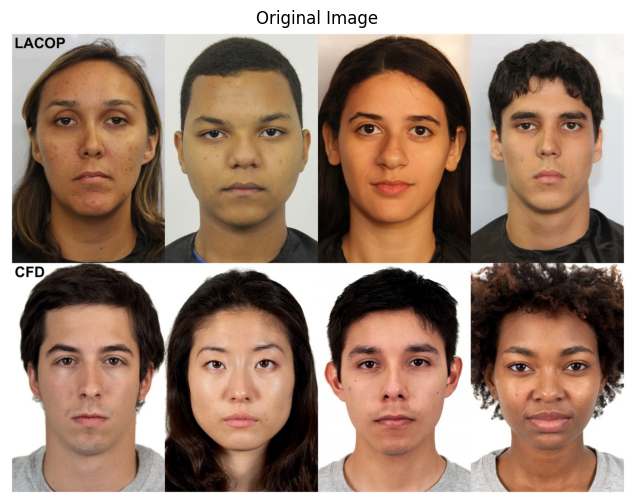

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from src.constants import RAW_DATA_PATH

# Path to data
image_file = os.path.join(RAW_DATA_PATH, "test.jpg")

# Load the image
image = cv2.imread(image_file)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

Using Haar Cascade XML from OpenCV for face detection. It's a pre-trained classifier

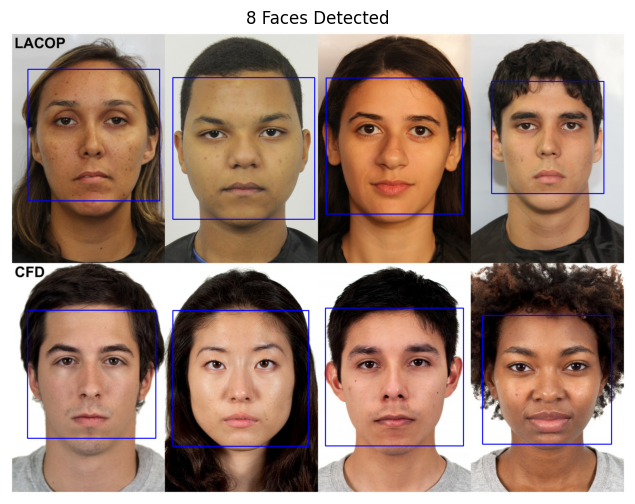

In [3]:
import cv2
from pathlib import Path
# Path to Pre Trained Haar Cascade
from src.constants import (PRE_TRAINED_HAARCASCADE_CLASSIFIER_PATH,
                            RAW_DATA_PATH,
                            PROCESSED_DATA_PATH)


# Create face detector
face_cascade = cv2.CascadeClassifier(PRE_TRAINED_HAARCASCADE_CLASSIFIER_PATH)

# Function to detect faces in an image
def detect_faces(image):
    # Convert the image to grayscale (Haar cascades work with grayscale images)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray_image,       # Grayscale image
        scaleFactor=1.1,  # Scale factor
        minNeighbors=5,   # Minimum number of neighbors
        minSize=(30, 30)  # Minimum size of the face
    )
    return faces

# Detect faces in the image
detected_faces = detect_faces(image)

# Function to draw rectangles around faces
def draw_faces(image, faces):
    image_copy = image.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Draw rectangle around faces
    return image_copy

# Draw rectangles around faces
image_with_faces = draw_faces(image_rgb, detected_faces)


plt.figure(figsize=(8, 6))
plt.imshow(image_with_faces)
plt.title(f"{len(detected_faces)} Faces Detected")
plt.axis("off")
plt.show()


This function applies a blurring effect to detected faces in an image. It uses a pre-trained face detection model to identify them and then applies a Gaussian blur to each detected face region. This can be useful for privacy protection in images or videos where faces need to be obscured.

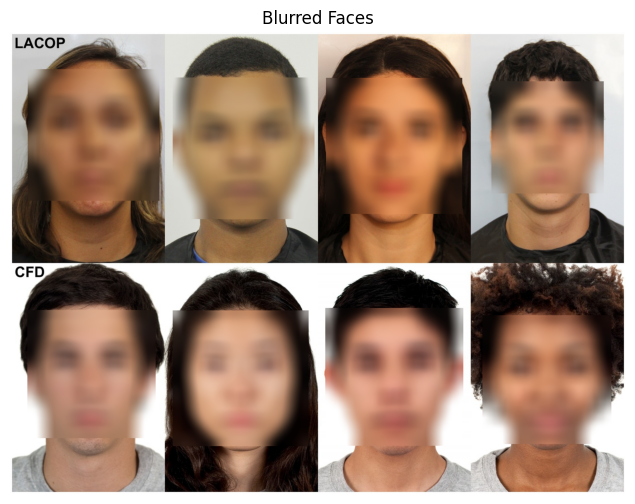

In [4]:
# function to blur faces in an image using a Gaussian filter
def blur_faces(image, faces):
    blurred_image = image.copy()
    for (x, y, w, h) in faces:
        # Extract the region of interest (the face) from the image
        face_region = blurred_image[y:y+h, x:x+w]

        # Apply Gaussian blur to the face region
        blurred_face = cv2.GaussianBlur(face_region, (51, 51), 30)

        # Put the blurred face region back into the image
        blurred_image[y:y+h, x:x+w] = blurred_face
    return blurred_image

# Blur faces in the image
blurred_image = blur_faces(image_rgb, detected_faces)

plt.figure(figsize=(8, 6))
plt.imshow(blurred_image)
plt.title("Blurred Faces")
plt.axis("off")
plt.show()


Testing video


In [5]:
def process_video(input_path, output_path, face_cascade_path):
    """
    Processes a video to detect and blur faces frame by frame.

    Args:
        input_path (str): Path to the input video.
        output_path (str): Path to the output video.
        face_cascade_path (str): Path to the Haar Cascade file.
    """
    # Load the Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(face_cascade_path)

    # Open the video file
    video_capture = cv2.VideoCapture(input_path)
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_size = (width, height)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Video Codec
    Path(os.path.dirname(output_path)).mkdir(parents=True, exist_ok=True) #Create parent directory of output_path if it doesn't exist
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break  # No more frames to read

        # Find faces in frames
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Apply the blur method to the faces
        processed_frame = blur_faces(frame, faces)


        # Write the processed frame
        video_writer.write(processed_frame)

    # Release the VideoCapture and VideoWriter objects
    video_capture.release()
    video_writer.release()
    print(f"Processed video saved at: {output_path}")


# Path to the input video
input_video_path = os.path.join(RAW_DATA_PATH, "test.mp4")
output_video_path = os.path.join(PROCESSED_DATA_PATH, "gaussian_blur-pre_trained_haar-test.mp4")

# Process the video
process_video(input_video_path, output_video_path, PRE_TRAINED_HAARCASCADE_CLASSIFIER_PATH)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Processed video saved at: /home/sebastiano/Documents/UNI_MS/year_1/semester_1/signal_image_video-Rosani/face-blurrer/data/processed/gaussian_blur-pre_trained_haar-test.mp4


**Using YOLO**

Now we can load the model and see the result

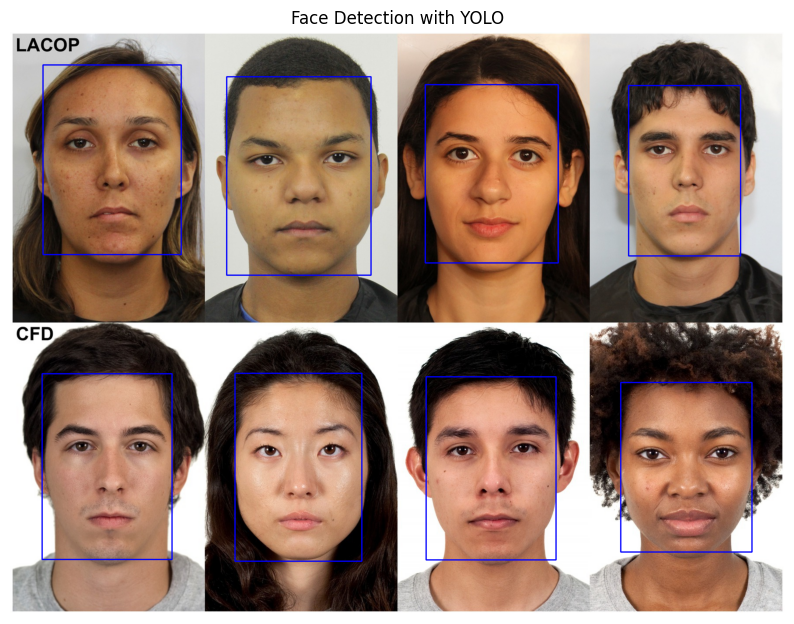

In [6]:
from src.yolo import load_yolo_model, detect_faces_yolo

yolo_net, yolo_classes = load_yolo_model()
output_layers = yolo_net.getUnconnectedOutLayersNames()

# Load the image
image_file = os.path.join(RAW_DATA_PATH, "test.jpg")
image = cv2.imread(image_file)

# Detect faces in the image using YOLO
detected_faces = detect_faces_yolo(image, yolo_net, output_layers)

# Draw rectangles around the detected faces
for (x, y, w, h) in detected_faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Show the image with detected faces
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Face Detection with YOLO")
plt.show()

Complete code for video detection

In [7]:
import cv2

# Load the YOLOv3 model
yolo_net, yolo_classes = load_yolo_model()
output_layers = yolo_net.getUnconnectedOutLayersNames()

# Path to the input video
video_path = os.path.join(RAW_DATA_PATH, "test.mp4")
video_capture = cv2.VideoCapture(video_path)

# Option for the output video
output_path = os.path.join(PROCESSED_DATA_PATH, "face-recognition-yolo-test.avi")
fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Codec for the output video
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process the video frame by frame
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    # Face detection using YOLO
    detected_faces = detect_faces_yolo(frame, yolo_net, output_layers)

    # Draw rectangles around the detected faces
    for (x, y, w, h) in detected_faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save the processed frame
    out.write(frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture and VideoWriter objects
video_capture.release()
out.release()
cv2.destroyAllWindows()